In [3]:
import anndata
import pandas as pd
from imblearn.over_sampling import SMOTE
import scipy as sc
from scipy import io
from scipy import sparse
#run and test model
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import make_scorer,precision_recall_fscore_support, classification_report
import numpy as np
testgenes=pd.read_csv("20210605top100scRFE.csv", sep=",")
testgenes=testgenes.loc[1:,:]
testgenes=list(testgenes.nlargest(200,"Freq")['genes'])
#load in data and shove in Anndata
matrix=io.mmread("NormalizedJackData.mtx").tocsr()
cells=open("CellnamesJack.csv", "r").read().splitlines()
genes=open("GenenamesJack.csv", "r").read().splitlines()
matrix=anndata.AnnData(X=matrix.T)
matrix.var_names=genes
matrix.obs_names=cells
#loading cell subsets for annotation 
jackcells=open("ClonesHIVJackData.csv", "r").read().splitlines()
Runxiacells=open("ClonesHIVRunxiaData.csv", "r").read().splitlines()

In [4]:
#run and test model

#step 1 subset to the select genes
cur=matrix[:,testgenes]
#step 2 subset to the cells of interest
#first annotate all the HIV-1 clones

cur.obs['HIVclone']=cur.obs_names.isin(Runxiacells+jackcells) 
#split off the ones from Runxia's data for final validation

Runxia=cur[Runxiacells,:]

notRunxia = [name for name in matrix.obs_names if name not in Runxiacells]
cur=cur[notRunxia, :]
#step 3 wrangle data

X=sparse.csr_matrix(cur.X)
y=cur.obs['HIVclone']

X_train, X_test, y_train, y_test = train_test_split(
     X, y, test_size=0.20, random_state=42)
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

#train and test model on training data 
rf = RandomForestClassifier( random_state = 1,
                                 n_jobs = -1, oob_score = True, min_samples_leaf =64, n_estimators =1200)

rf.fit(X_train, y_train) 


pred=rf.predict(X_train)
print(classification_report(y_train,pred))

#step 4, see how it does on the test set 

pred=rf.predict(X_test)
print(classification_report(y_test,pred))

#step 5, how does it do on the held out set from runxia 

pred=rf.predict(sparse.csr_matrix(Runxia.X))
print(classification_report(Runxia.obs['HIVclone'],pred))

Trying to set attribute `.obs` of view, copying.


              precision    recall  f1-score   support

       False       1.00      0.98      0.99     62373
        True       0.99      1.00      0.99     62373

    accuracy                           0.99    124746
   macro avg       0.99      0.99      0.99    124746
weighted avg       0.99      0.99      0.99    124746

              precision    recall  f1-score   support

       False       1.00      0.98      0.99     15601
        True       0.22      0.70      0.34        97

    accuracy                           0.98     15698
   macro avg       0.61      0.84      0.66     15698
weighted avg       0.99      0.98      0.99     15698

              precision    recall  f1-score   support

       False       0.00      0.00      0.00         0
        True       1.00      0.56      0.72       248

    accuracy                           0.56       248
   macro avg       0.50      0.28      0.36       248
weighted avg       1.00      0.56      0.72       248



/gpfs/ysm/project/ya-chi_ho/jac369/conda_envs/sklearn2/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [18]:
#generating AUC 
from sklearn.metrics import roc_curve, auc, roc_auc_score

#AUC on just unstimulated data unseen
pred=rf.predict_proba(X_train)
fpr_train, tpr_train, thresholds_train = roc_curve(y_train,pred[:,1])
score_train=roc_auc_score(y_train,pred[:,1])
#AUC on the training dataset 
pred=rf.predict_proba(X_test)
fpr_test, tpr_test, thresholds_test = roc_curve(y_test,pred[:,1])
score_test=roc_auc_score(y_test,pred[:,1])

#AUC not possible on Runxia's data because her data doesnt give us a negative class. 

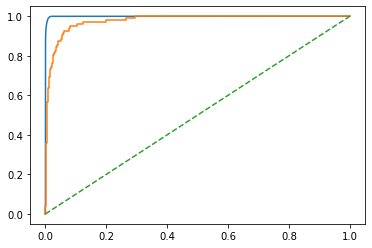

In [35]:
import matplotlib.pyplot as plt

plt.plot(fpr_train, tpr_train)
plt.plot(fpr_test, tpr_test)
plt.plot([0,1],[0,1], '--')

plt.savefig('modelperformance.eps', format='eps')
#scores are 0.9996 for train and 0.9777 for test 

In [12]:
with open("runxiaresultsnew.txt", 'w') as f:
    for value in pred: 
        f.write(str(value))
        
pred=rf.predict(X_test)
print(classification_report(y_test,pred))

with open("Jackresultsnew.txt", 'w') as f:
    for value in pred: 
        f.write(str(value))
        
y_test.to_csv("JackTruthnew.txt")